<a href="https://colab.research.google.com/github/ujjawalsingh10/Sentiment-Analysis-on-IMDB-Reviews/blob/main/Sentiment_Analysis_with_BERT_in_HuggingFace.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Installation

In [3]:
!pip install transformers datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 44.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.1/519.1 kB 56.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 114.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 79.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 19.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 26.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 21.1 MB/s eta 0:00:00


In [4]:
import tensorflow as tf### models
import numpy as np### math computations
import matplotlib.pyplot as plt### plotting bar chart
import sklearn### machine learning library
import cv2## image processing
from sklearn.metrics import confusion_matrix, roc_curve### metrics
import seaborn as sns### visualizations
import datetime
import pathlib
import io
import os
import re
import string
import time
from numpy import random
import gensim.downloader as api
from PIL import Image
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import Dense,Flatten,InputLayer,BatchNormalization,Dropout,Input,LayerNormalization
from tensorflow.keras.losses import BinaryCrossentropy,CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy,TopKCategoricalAccuracy, CategoricalAccuracy, SparseCategoricalAccuracy
from tensorflow.keras.optimizers import Adam
from google.colab import drive
from google.colab import files
from datasets import load_dataset
from transformers import (BertTokenizerFast,TFBertTokenizer,BertTokenizer,RobertaTokenizerFast,
                          DataCollatorWithPadding,TFRobertaForSequenceClassification,TFBertForSequenceClassification,
                          TFBertModel,create_optimizer)


In [5]:
BATCH_SIZE = 4

## Data Preparation

In [6]:
dataset_id = 'imdb'
dataset = load_dataset(dataset_id)

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [7]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

In [8]:
dataset['train'][0]

{'text': 'I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far be

In [9]:
model_id = "bert-base-uncased"
# tokenizer = BertTokenizer.from_pretrained(model_id)
tokenizer = BertTokenizerFast.from_pretrained(model_id)

In [10]:
tokenizer.is_fast

True

In [15]:
test_input_1 = 'The weather today is Great! zwp'
test_input_2 = 'How are you doing?'

tokenizer.tokenize(test_input_1, test_input_2)

['the',
 'weather',
 'today',
 'is',
 'great',
 '!',
 'z',
 '##w',
 '##p',
 'how',
 'are',
 'you',
 'doing',
 '?']

In [16]:
tokenizer(test_input_1, test_input_2)  ## 101 is cls token and 102 is sep token and rest is for the sentence

{'input_ids': [101, 1996, 4633, 2651, 2003, 2307, 999, 1062, 2860, 2361, 102, 2129, 2024, 2017, 2725, 1029, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

Token_ids are `segment embeddings` form the BERT input representation where, 0's in token id is for first sentence and 1's for the second

In [17]:
test_input_1 = 'The weather today is Great! zwp'
test_input_2 = 'How are you doing?'
inputs = [test_input_1, test_input_2]

tokenizer.tokenize(inputs)

['the',
 'weather',
 'today',
 'is',
 'great',
 '!',
 'z',
 '##w',
 '##p',
 'how',
 'are',
 'you',
 'doing',
 '?']

In [44]:
output = tokenizer(inputs, padding = True, truncation=True)#, max_length = 128) ## Padding used to make the sentences length similar, by def max_length is 512
print(output)

{'input_ids': [[101, 1996, 4633, 2651, 2003, 2307, 999, 1062, 2860, 2361, 102], [101, 2129, 2024, 2017, 2725, 1029, 102, 0, 0, 0, 0]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0]]}


Attention mask 0's tells us the positions we dont need to attend to

In [45]:
tokenizer.decode(output['input_ids'][0])

'[CLS] the weather today is great! zwp [SEP]'

In [46]:
tokenizer.decode(output['input_ids'][1])

'[CLS] how are you doing? [SEP] [PAD] [PAD] [PAD] [PAD]'

In [47]:
def preprocess_function(examples):
  return tokenizer(examples['text'], padding = True, truncation = True, max_length = 128)

In [48]:
tokenized_dataset = dataset.map(preprocess_function, batched = True)

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

In [49]:
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 50000
    })
})

In [50]:
tokenized_dataset['train'][0]

{'text': 'I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far be

In [51]:
# data_collator = DataCollatorWithPadding(tokenizer = tokenizer, return_tensors = 'tf')

In [52]:
tf_train_dataset = tokenized_dataset['train'].to_tf_dataset(
    columns = ['input_ids', 'token_type_ids', 'attention_mask', 'label'],
    shuffle = True,
    batch_size = BATCH_SIZE,
    # collate_fn = data_collator
)

In [53]:
tf_val_dataset = tokenized_dataset['test'].to_tf_dataset(
    columns = ['input_ids', 'token_type_ids', 'attention_mask', 'label'],
    shuffle = True,
    batch_size = BATCH_SIZE,
    # collate_fn = data_collator
)

In [60]:
## function to separate labels from the input dict.
def swap_positions(dataset):
  return {
      'input_ids' : dataset['input_ids'],
      'token_type_ids' : dataset['token_type_ids'],
      'attention_mask' : dataset['attention_mask']
  }, dataset['label']

In [61]:
tf_train_dataset = tf_train_dataset.map(swap_positions)
tf_val_dataset = tf_val_dataset.map(swap_positions)

In [62]:
for i in tf_train_dataset.take(1):
  print(i)

({'input_ids': <tf.Tensor: shape=(4, 128), dtype=int64, numpy=
array([[  101,  5436, 19962, 22599,  1024,  2043,  2010,  2564,  1010,
         1037,  2739,  6398,  1010,  2003, 11364,  1004,  2999,  2007,
         2019, 11924,  3313,  1010,  3595,  2326,  4005,  4388,  8109,
         3162,  2014,  2091,  1004, 26944,  2015,  1037,  2933,  2011,
         2019,  2608, 11033,  2000,  3443,  2019,  2390,  1997, 25018,
        11924,  2015,  2000, 25683,  2088,  4177,  1012,  1026,  7987,
         1013,  1028,  1026,  7987,  1013,  1028,  1045,  2347,  1005,
         1056,  8074,  2172,  2043,  1045,  2034,  2387,  2023,  8297,
         2000,  2957, 27233,  2378,  1005,  1055,  2659,  1011,  5166,
        16596,  1011, 10882,  1013,  2895,  8893,  1000, 16941, 27080,
         1000,  1012,  2008,  2143,  2001,  2498,  2569,  1010,  2025,
         2000,  5254,  1037,  1038, 20051,  4630, 10973,  1011,  2125,
         1997,  2119,  1000,  1996,  2744, 23207,  1000,  1004,  1000,
         6487,

## Modelling

In [55]:
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels = 2)

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [56]:
model.summary()

Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_37 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
Total params: 109,483,778
Trainable params: 109,483,778
Non-trainable params: 0
_________________________________________________________________


# Training

In [57]:
num_epochs = 3
batches_per_epoch = len(tokenized_dataset['train']) // BATCH_SIZE
total_train_steps = int(batches_per_epoch * num_epochs)

In [58]:
optimizer, schedule = create_optimizer(init_lr = 2e-5, num_warmup_steps = 0, num_train_steps = total_train_steps)

In [63]:
model.compile(
    optimizer = optimizer,
    metrics = ['accuracy'],
)

In [65]:
history = model.fit(
    tf_train_dataset,
    validation_data = tf_val_dataset,
    epochs = 3
)

Epoch 1/3
6250/6250 [==============================] - 1266s 194ms/step - loss: 0.3334 - accuracy: 0.8550 - val_loss: 0.2814 - val_accuracy: 0.8809
Epoch 2/3
6250/6250 [==============================] - 1182s 189ms/step - loss: 0.1655 - accuracy: 0.9368 - val_loss: 0.2930 - val_accuracy: 0.8890
Epoch 3/3
6250/6250 [==============================] - 1194s 191ms/step - loss: 0.0504 - accuracy: 0.9841 - val_loss: 0.4072 - val_accuracy: 0.8887


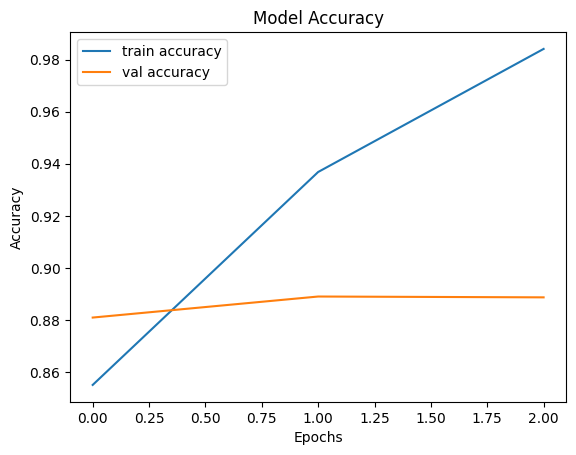

In [66]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train accuracy', 'val accuracy'])
plt.show()

In [67]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [68]:
model.save('/content/drive/MyDrive/Deep_Learning/NLP/Sentiment_Analysis_on_IMBD/bert_weights')